### Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read the channel impulse response (CSV to pd.DataFrame)
- The channel impulse response is the same for all files

In [2]:
channel = pd.read_csv("channel.csv", header=None)
channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       30 non-null     float64
dtypes: float64(1)
memory usage: 368.0 bytes


### Read the files (CSV to pd.DataFrame)

In [7]:
file_1 = pd.read_csv("file1.csv", header=None)
file_2 = pd.read_csv("file2.csv", header=None)
file_3 = pd.read_csv("file3.csv", header=None)
file_4 = pd.read_csv("file4.csv", header=None)
file_5 = pd.read_csv("file5.csv", header=None)
file_6 = pd.read_csv("file6.csv", header=None)
file_7 = pd.read_csv("file7.csv", header=None)
file_8 = pd.read_csv("file8.csv", header=None)
file_9 = pd.read_csv("file9.csv", header=None)
raw_files = [file_1, file_2, file_3, file_4, file_5, file_6, file_7, file_8, file_9]

### Check the length of the received signal
- The received signal should have a length which is a multiple of the OFDM symbol length

In [10]:
i = 1
for file in raw_files:
    if len(np.array(file)) % (1024 + 32) != 0:
        print("File_", i, " is not divisible by the OFDM symbol length")
    else:
        print("File_", i, "is divisible by the OFDM symbol length")
    i += 1

File_ 1 is divisible by the OFDM symbol length
File_ 2 is divisible by the OFDM symbol length
File_ 3 is divisible by the OFDM symbol length
File_ 4 is divisible by the OFDM symbol length
File_ 5 is divisible by the OFDM symbol length
File_ 6 is divisible by the OFDM symbol length
File_ 7 is divisible by the OFDM symbol length
File_ 8 is divisible by the OFDM symbol length
File_ 9 is divisible by the OFDM symbol length


### Divide the received signal into OFDM symbols
- The length of the OFDM symbols is specified in the Moodle assignment: 1024 (DFT block) + 32 (inserted prefix)

In [12]:
received_block_files = []
for file in raw_files:
    dimension_param = int(len(np.array(file)) / (1024 + 32))
    received_block_files.append(np.array(file).reshape(dimension_param, 1056))
for file in received_block_files:
    print(file.shape)

(950, 1056)
(362, 1056)
(1519, 1056)
(1026, 1056)
(545, 1056)
(276, 1056)
(962, 1056)
(1363, 1056)
(459, 1056)


### Remove the cyclic prefix of size 32 from the front of every OFDM block

In [13]:
prefix_free_block_files = []
for file in received_block_files:
    prefix_free_block_files.append(file[:,32:])

### Perform Fast Fourier Transform (FFT) on the received OFDM block without prefix

In [14]:
fft_files = []
for file in prefix_free_block_files:
    fft_files.append(np.fft.fft(file, axis=1))

In [15]:
for file in fft_files:
    print(file.shape)

(950, 1024)
(362, 1024)
(1519, 1024)
(1026, 1024)
(545, 1024)
(276, 1024)
(962, 1024)
(1363, 1024)
(459, 1024)


### Take only the 2nd to 511th elements in each transformed OFDM block

In [41]:
half_block_files = []
for file in fft_files:
    half_block_files.append(np.array(file[:,1:512]))

### Perform Fast Fourier Transform (FFT) on the channel impulse response

In [42]:
H = np.fft.fft(np.array(channel).flatten(), n=1024)[1:512]

### Equalise the constellations to have energy close to 0 (CHECK DESCRIPTION CORRECTNESS)

In [44]:
equalised_files = []
for file in half_block_files:
    temp_file = file / H
    temp_file /= np.sqrt(np.mean(np.abs(temp_file)**2))
    equalised_files.append(temp_file)

### Plot the constellations to visualise the QPSK set up

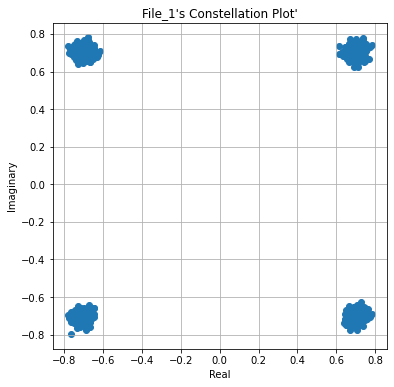

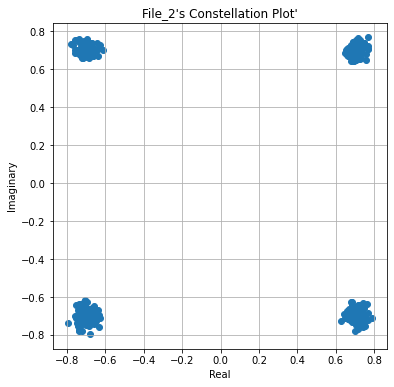

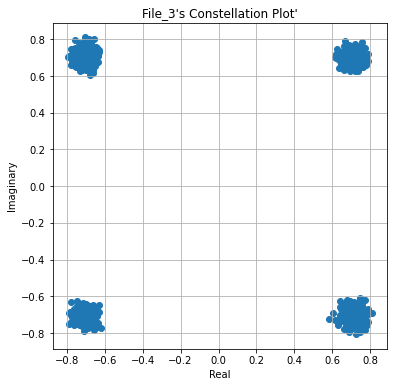

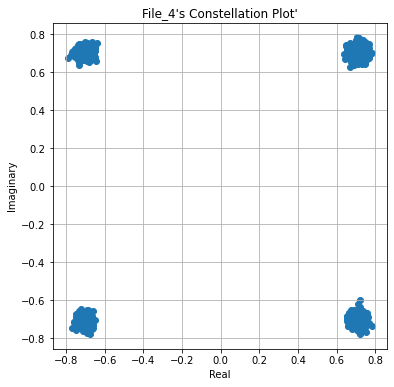

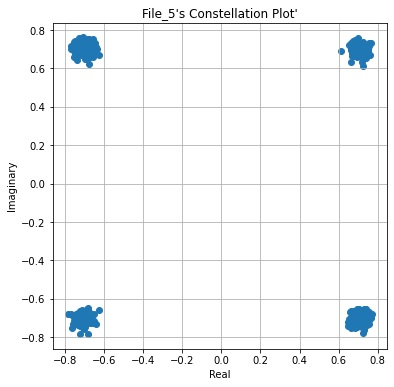

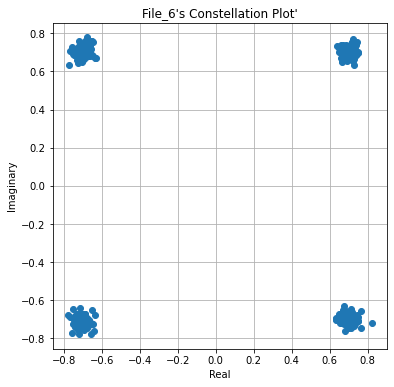

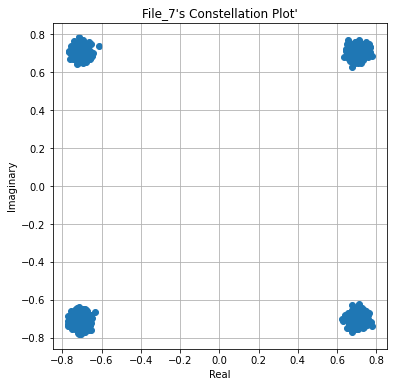

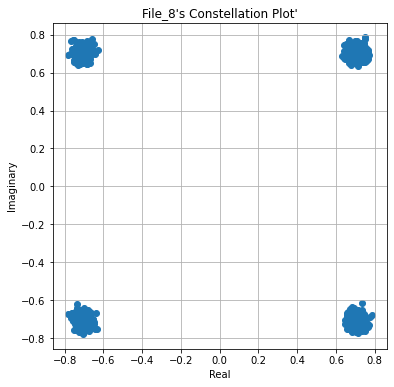

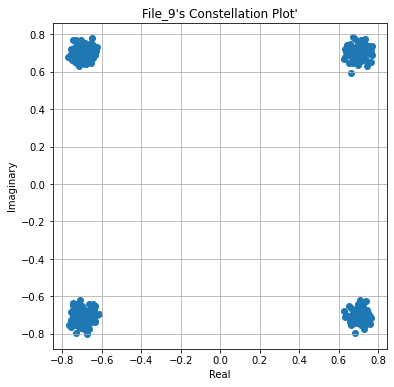

In [47]:
count = 1
for idx, points in enumerate(equalised_files):
    real_parts = [point[0].real for point in points]
    imag_parts = [point[0].imag for point in points]
    
    plt.figure(figsize=(6,6))
    plt.scatter(real_parts, imag_parts)
    plt.title(f"File_{idx + 1}'s Constellation Plot'")
    plt.xlabel("Real")
    plt.ylabel("Imaginary")
    plt.grid(True)
    plt.show()
    count += 1

### Define a function to demap the constellations and turn them back to two bits

In [48]:
def qpsk_demapper(symbol):
    bit0 = (symbol.imag < 0).astype(np.uint8)
    bit1 = (symbol.real < 0).astype(np.uint8)
    return np.stack((bit0, bit1), axis=-1)

In [49]:
decoded_files = []
for file in equalised_files:
    decoded_files.append(qpsk_demapper(file).reshape(-1))

In [50]:
for file in decoded_files:
    print(file.shape)

(970900,)
(369964,)
(1552418,)
(1048572,)
(556990,)
(282072,)
(983164,)
(1392986,)
(469098,)


In [51]:
byte_files = []
for file in decoded_files:
    byte_files.append(np.packbits(file[:((len(file) // 8)*8)].reshape(-1, 8), axis=1).flatten())

In [52]:
for file in byte_files:
    print(file.shape)

(121362,)
(46245,)
(194052,)
(131071,)
(69623,)
(35259,)
(122895,)
(174123,)
(58637,)


### Extract the file names

In [58]:
name_terminators = []
names = []
for file in byte_files:
    file_name_terminate = np.where(file == 0)[0][0]
    name_terminators.append(file_name_terminate)
    name = file[:file_name_terminate].tobytes().decode("utf-8")
    names.append(name)
    print(name)

files/3829010287.tiff
files/2784058210.wav
files/1984570931.tiff
files/4738210983.tiff
files/5091376048.tiff
files/6884643201.wav
files/7256301952.tiff
files/8931746329.tiff
files/9103751287.wav


### Extract the file size

In [54]:
size_terminators = []
file_sizes = []
for i in range(len(name_terminators)):
    file_size_terminate = np.where(byte_files[i] == 0)[0][1]
    size_terminators.append(file_size_terminate)
    size = int(byte_files[i][name_terminators[i]+1:file_size_terminate].tobytes().decode("utf-8"))
    print(size)
    file_sizes.append(size)

121206
46124
193994
130932
69482
35202
122790
174068
58584


### Extract file content

In [59]:
contents = {}
for i in range(len(size_terminators)):
    contents[names[i]] = byte_files[i][(size_terminators[i] + 1):(size_terminators[i] + 1 + file_sizes[i])]
    # contents.append(byte_files[i][(size_terminators[i] + 1):(size_terminators[i] + 1 + file_sizes[i])])

In [60]:
contents

{'files/3829010287.tiff': array([ 73,  73,  42, ..., 204,   1,   0], dtype=uint8),
 'files/2784058210.wav': array([ 82,  73,  70, ..., 127, 127, 127], dtype=uint8),
 'files/1984570931.tiff': array([ 73,  73,  42, ..., 213,   2,   0], dtype=uint8),
 'files/4738210983.tiff': array([ 73,  73,  42, ..., 222,   1,   0], dtype=uint8),
 'files/5091376048.tiff': array([73, 73, 42, ..., 13,  1,  0], dtype=uint8),
 'files/6884643201.wav': array([ 82,  73,  70, ..., 127, 126,   0], dtype=uint8),
 'files/7256301952.tiff': array([ 73,  73,  42, ..., 204,   1,   0], dtype=uint8),
 'files/8931746329.tiff': array([ 73,  73,  42, ..., 151,   2,   0], dtype=uint8),
 'files/9103751287.wav': array([ 82,  73,  70, ..., 127, 128,   0], dtype=uint8)}

In [61]:
count = 1
for file_name in contents:
    if ".tiff" in file_name:
        with open(f"File_{count}.tiff", "wb") as f:
            f.write(contents[file_name].tobytes())
    elif ".wav" in file_name:
        with open(f"File_{count}.wav", "wb") as f:
            f.write(contents[file_name].tobytes())
    else:
        print("Error in file name extraction")
    count += 1